## Optimization methods

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

import torch
import random
from IPython import display
from sklearn import datasets, preprocessing

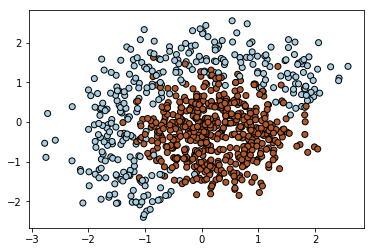

In [45]:
(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = (y==1) | (X[:,1] > X[:,0] - 0.5)

X = X[ind,:]
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
plt.show()

X, y = torch.FloatTensor(X), torch.FloatTensor(y)

In [46]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter, title_message):    
    plt.clf()
    xy = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    Z = classify(xy, w)
    
    Z = Z.numpy()
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title_message)
    plt.subplot(1,2,2)
    plt.plot(loss)
    plt.grid()
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())


In [4]:
def expand(X):
    prod = X[:,0] * X[:,1]
    prod = prod.unsqueeze(1)
    oness = torch.ones_like(X[:, 0])
    oness = oness.unsqueeze(1)
    res = torch.cat([X, X ** 2, prod, oness], dim=1)
    return torch.FloatTensor(res)

def classify(X, w):
    """
    Given feature matrix X [n_samples,2] and weight vector w [6],
    return an array of +1 or -1 predictions
    
    dimensions:
    X(n x 6) * w(6 x 1) = y(n x 1)
    y[const1, const2] -> y[-1, 1]
    """

    return torch.mv(expand(X), w).sign()

$$ L =  \frac{1}{N} \displaystyle\sum_{i=1}^{N} max(0,1-y_i \cdot  w^T x_i) $$


In [23]:
def compute_loss(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute scalar loss function using formula above.
    
    dimensions:
    y(n x 1) scal*  ( w_t(1 x 6) * x(6 x n) ) 
    y(n x 1) scal*  (         (1 x n)       )
    """
    
    N = X.shape[0]
    tmp = 1 - y * w.reshape(1, 6).mm(expand(X).t())
    return (1 / N) * torch.clamp(tmp, min=0).sum()

In [35]:
def compute_grad(X, y, w):
    """
    Given feature matrix X [n_samples,2], target vector [n_samples] of +1/-1,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    
    dimensions:
    y(n x 1)
    x(n x 6) 
    """
    N = X.shape[0]
    
    tmp = -y.unsqueeze(1) * expand(X)
    der = torch.where((y * w.reshape(1, 6).mm(expand(X).t())).reshape(N, 1) < 1,
                      tmp,
                      torch.zeros(tmp.shape))
    
    return (1 / N) * der.sum(dim=0)
    

### Gradient descent

Find an optimal learning rate for **gradient descent** for given batch size.

In [47]:
def GD(alpha):
    w = torch.Tensor([1, 0, 0, 0, 0, 0])

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        visualize(X[ind,:], y[ind], w, loss, n_iter, "alpha = {}".format(alpha))

        w = w - alpha * compute_grad(X[ind,:], y[ind], w)


    visualize(X, y, w, loss, n_iter, "alpha = {}".format(alpha))
    plt.clf()

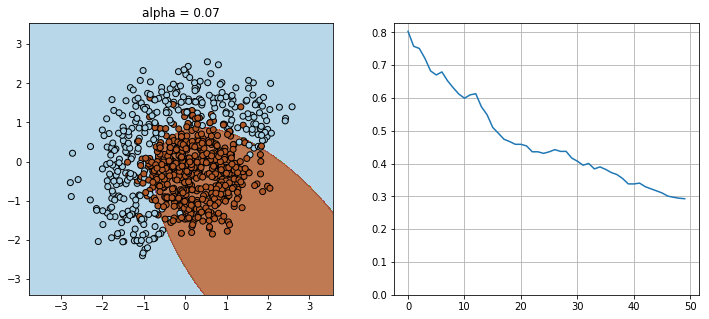

CPU times: user 24.2 s, sys: 16.7 s, total: 41 s
Wall time: 14.1 s


<Figure size 864x360 with 0 Axes>

In [48]:
%%time


alpha = 0.07
GD(alpha)

### Momentum

Implement **gradient descent with momentum** and test it's performance for different learning rate and momentum values.

In [51]:
def GD_with_momentum(alpha, mu):
    w = torch.Tensor([1, 0, 0, 0, 0, 0])
    
    v = torch.zeros_like(w)

    n_iter = 50
    batch_size = 4
    loss = np.zeros(n_iter)
    plt.figure(figsize=(12,5))
    for i in range(n_iter):
        ind = random.sample(range(X.shape[0]), batch_size)
        loss[i] = compute_loss(X, y, w)
        visualize(X[ind,:], y[ind], w, loss, n_iter, "alpha = {}, mu = {}".format(alpha, mu))

        v = mu * v - alpha * compute_grad(X[ind,:], y[ind], w)
        w += v 

    visualize(X, y, w, loss, n_iter, "alpha = {}, mu = {}".format(alpha , mu))
    plt.clf()

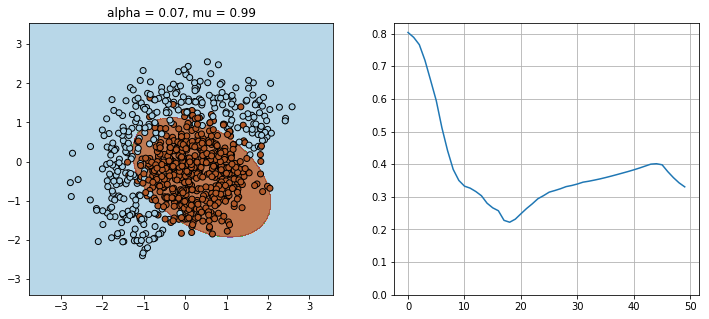

CPU times: user 23.8 s, sys: 16.9 s, total: 40.7 s
Wall time: 14 s


<Figure size 864x360 with 0 Axes>

In [52]:
%%time


alpha = 0.07
mu = 0.99

GD_with_momentum(alpha, mu)

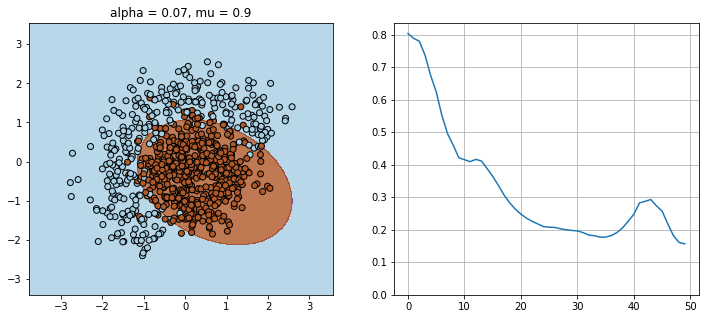

CPU times: user 24.4 s, sys: 16.6 s, total: 41 s
Wall time: 14.2 s


<Figure size 864x360 with 0 Axes>

In [53]:
%%time


alpha = 0.07
mu = 0.9

GD_with_momentum(alpha, mu)

### Nesterov's accelerated gradient

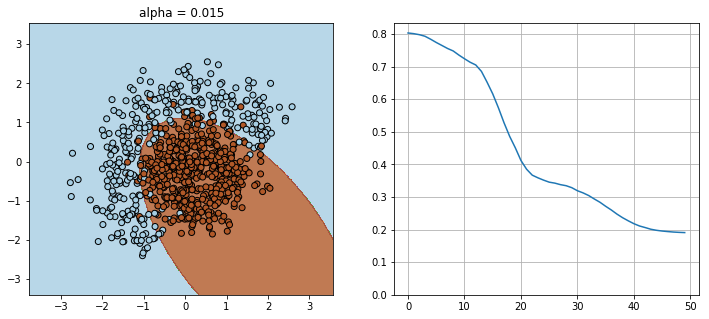

<Figure size 864x360 with 0 Axes>

In [56]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])

alpha = 0.015 # learning rate
mu    = 0.9 # momentum

v = torch.zeros_like(w)

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter, "alpha = {}".format(alpha))
    
    new_w = w + mu * v
    v = mu * v - alpha * compute_grad(X[ind,:], y[ind], new_w)
    w += v

visualize(X, y, w, loss, n_iter, "alpha = {}".format(alpha))
plt.clf()

Finally, try **Adam algorithm**. You can start with beta = 0.9 and mu = 0.999

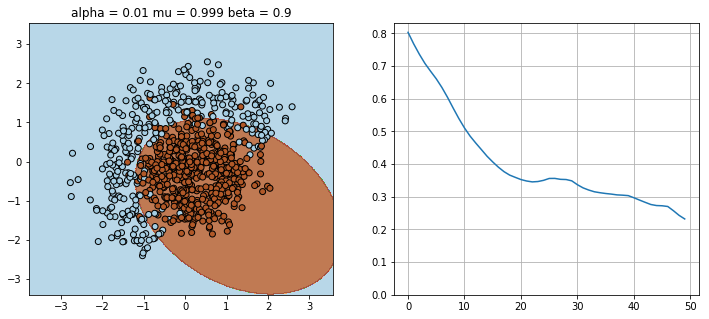

<Figure size 864x360 with 0 Axes>

In [59]:
w = torch.Tensor([1, 0, 0, 0, 0, 0])
c_w = 0

alpha = 0.01# learning rate
beta = 0.9 # (beta1 coefficient in original paper) exponential decay rate for the 1st moment estimates
mu = 0.999 # (beta2 coefficient in original paper) exponential decay rate for the 2nd moment estimates
eps = 0.001 # A small constant for numerical stability

v = torch.zeros_like(w)
g = torch.zeros_like(w)


n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter, "alpha = {} mu = {} beta = {}".format(alpha, mu, beta))
    
    grad = compute_grad(X[ind,:], y[ind], w)
    
    v = beta * v + (1 - beta) * grad
    g = mu * g + (1 - mu) * grad * grad
    
    w -= (alpha / (torch.sqrt(g) + eps)) * v
    
visualize(X, y, w, loss, n_iter, "alpha = {} mu = {} beta = {}".format(alpha, mu, beta))
plt.clf()